# 1. Initialize Environment

In [1]:
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install tensorflow
#!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np

import gc

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU
from keras.models import Sequential
from keras.metrics import top_k_categorical_accuracy
from keras.losses import categorical_crossentropy

from matplotlib import pyplot as plt

In [3]:
# set seed
tf.random.set_seed(43)

# 2. Data Preperation and Filtering

Session Dataset (train.jsonl) from: https://www.kaggle.com/competitions/otto-recommender-system/data

In [4]:
# Prints the total Number of Sessions we have in the whole dataset
print("Number of Sessions: ", str(sum(1 for line in open('Data/train.jsonl'))))

# We have too many sessions so we will reduce the size of the dataset by applying some filter rules

Number of Sessions:  12899779


In [5]:
# load subset of data because the complete data doesnt fit into memory
datasize = 350000
n = 1 
data = pd.DataFrame()
chunks = pd.read_json('Data/train.jsonl', lines=True, chunksize=datasize)

# load 1x 350000 session samples
for e, chunk in enumerate(chunks):
    if e < n:
        data = pd.concat([data, chunk])
    else:
        break

data

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...,...
349995,349995,"[{'aid': 1718006, 'ts': 1659345186158, 'type':..."
349996,349996,"[{'aid': 1598282, 'ts': 1659345186161, 'type':..."
349997,349997,"[{'aid': 19104, 'ts': 1659345186167, 'type': '..."
349998,349998,"[{'aid': 1276053, 'ts': 1659345186291, 'type':..."


In [6]:
# clear memory space
del chunk, chunks, datasize, e, n
gc.collect()

0

In [7]:
# splitting event information of all sessions into columns

# Create an empty list to store the expanded rows
expanded_rows = []

# Iterate over the rows of our dataset
for _, row in data.iterrows():
    session_data = row['events']  # get the session data
    session_id = row['session']  # get the session id
    
    # Iterate over the session data and create an expanded row for each session event
    for event in session_data:
        expanded_row = {
            'session': session_id,
            'aid': event['aid'],
            'ts': event['ts'],
            'type': event['type']
        }
        expanded_rows.append(expanded_row)

data = pd.DataFrame(expanded_rows)

data

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
16738060,349999,1010549,1659881154499,clicks
16738061,349999,1838993,1659881201146,clicks
16738062,349999,1838993,1659881320586,clicks
16738063,349999,1838993,1659881334196,carts


In [8]:
# clearning memory space
del expanded_row, expanded_rows, row, event, session_data, session_id
gc.collect()

0

In [9]:
# FIltering for articles that appear at least 1000 times
id_counts = data['aid'].value_counts()
print(len(data))

data = data[data['aid'].isin(id_counts[id_counts >= 1000].index)]
print(len(data))

16738065
1519350


In [10]:
# create a sequence of articles for each given session
train = data.groupby('session').agg({'aid':lambda x: list(x)})

# considering sessions of length of at least 3 and maximal 5
train = train[train.aid.map(len) >= 3]
train = train[train.aid.map(len) <= 5]

data2 = train.explode('aid')

In [11]:
# articles which appear at least 1000 times in sessions which have at least 3 articles and at most 5 articles
data2

,aid
session,
2,935830
2,935830
2,295985
4,255379
4,1838173
...,...
349990,1704956
349990,1704956
349990,824530


In [12]:
# applying filter (from data2) on our dataset
data = data[data['aid'].isin(data2['aid'])]

In [13]:
# dropping duplicates if they exist
data = data.drop_duplicates()

In [14]:
# clear memory space
del train, data2, id_counts
gc.collect()

0

In [6]:
# save preprocessed data to csv file
data.to_csv("preprocessed_data")

In [15]:
# clear memory space
del data
gc.collect()

0

# 3. Data Analysis and Statistics

In [16]:
# load the preprocessed data
data = pd.read_csv("Data/preprocessed_data")
data.head(5)

,Unnamed: 0,session,aid,ts,type
0,15,0,803544,1659371044075,clicks
1,30,0,1469630,1659531937070,clicks
2,40,0,394655,1659640824817,clicks
3,66,0,1840418,1660024261875,clicks
4,69,0,667924,1660024473559,clicks


In [7]:
# How many sessions the dataset has?
print("Count of unique Sessions: " + str(data['session'].nunique()))
print("Count of unique Articles: " + str(data['aid'].nunique()))

Count of unique Sessions: 184313
Count of unique Articles: 824


In [8]:
# How many actions/articles we have per session?

# Group by 'session_id' and count the actions
actions_by_session = data.groupby('session')['type'].count().reset_index()

# Rename the columns
actions_by_session.columns = ['session', 'action_count']

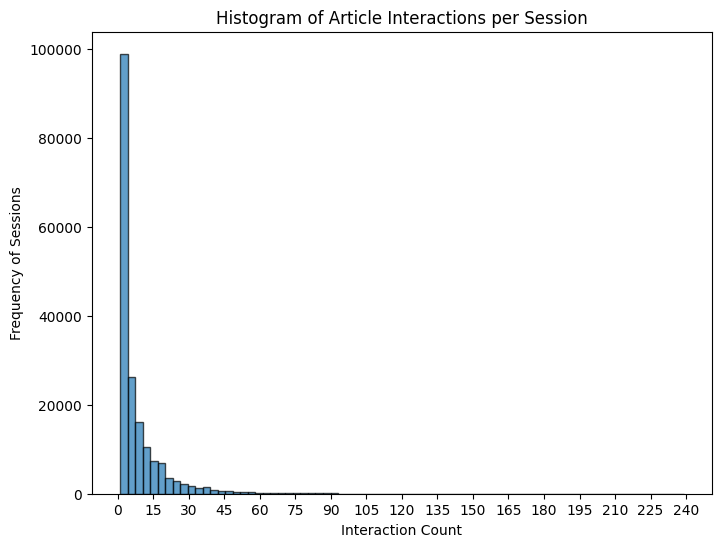

In [9]:
# plot it
plt.figure(figsize=(8, 6))
plt.hist(actions_by_session['action_count'], bins=75, edgecolor='black', alpha=0.7)
plt.xlabel('Interaction Count')
plt.ylabel('Frequency of Sessions')
plt.title('Histogram of Article Interactions per Session')

# defining ticks for the x axis
x_ticks = []

for i in range(0,251):
    if i % 15 == 0:
        x_ticks.append(i)

plt.xticks(x_ticks)
plt.show()

In [10]:
# Distribution of Session lengths

# Convert timestamp to datetime format
data['time'] = pd.to_datetime(data['ts'], unit='ms')

# Group data by session and calculate session start and end times
data_time_grouped = data.groupby('session')['time'].agg([min, max])

# Calculate session durations in days and sort them
data_time_grouped['duration'] = data_time_grouped['max'] - data_time_grouped['min']
session_durations_days = data_time_grouped['duration'].dt.days
session_durations_counts = session_durations_days.value_counts()
session_durations_sorted = session_durations_counts.sort_index()

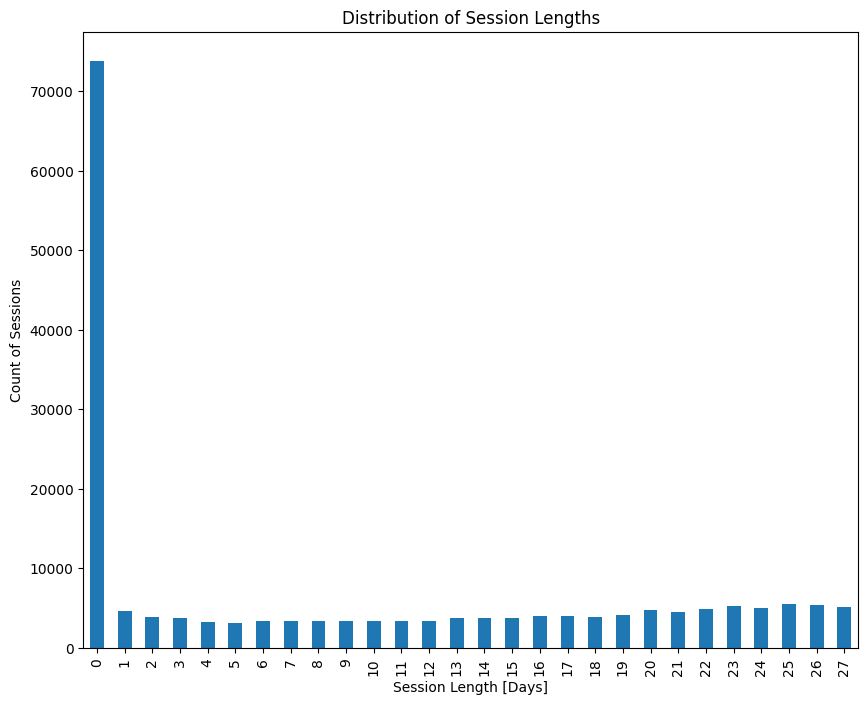

In [11]:
# plot it
session_durations_sorted.plot(kind='bar', figsize=(10, 8), title='Distribution of Session Lengths')
plt.xlabel('Session Length [Days]')
plt.ylabel('Count of Sessions')
plt.show()

In [12]:
# clear memory space
del actions_by_session, data_time_grouped, session_durations_days, session_durations_counts, session_durations_sorted, x_ticks, i
gc.collect()

15667

# 4. Prepare Data for Training

In [13]:
# Preparing Training and Test Data for our model

ids = np.arange(data.aid.nunique())
np.random.shuffle(ids)

# mapping article id to integer encoding 
aid_mapping = {i:j for i, j in zip(data.aid.unique(), ids)}

data['aid_id'] = data['aid'].map(aid_mapping)

data.head(5)

,Unnamed: 0,session,aid,ts,type,time,aid_id
0,15,0,803544,1659371044075,clicks,2022-08-01 16:24:04.075,689
1,30,0,1469630,1659531937070,clicks,2022-08-03 13:05:37.070,804
2,40,0,394655,1659640824817,clicks,2022-08-04 19:20:24.817,552
3,66,0,1840418,1660024261875,clicks,2022-08-09 05:51:01.875,784
4,69,0,667924,1660024473559,clicks,2022-08-09 05:54:33.559,691


In [14]:
# clear memory space
del ids, aid_mapping
gc.collect()

0

In [15]:
# create a sequence of articles for each session
train = data.groupby('session').agg({'aid_id':lambda x: list(x)})

# considering session where we have atleast a sequence of 3 and most of 5
train = train[train.aid_id.map(len) >= 3]
train = train[train.aid_id.map(len) <= 5]

# Number of Items/Articles
NUM_ITEMS = train.explode('aid_id').aid_id.nunique()
print(NUM_ITEMS)

824


In [16]:
train.head(5)

,aid_id
session,
2,"[76, 76, 181]"
4,"[625, 749, 749, 625]"
13,"[7, 755, 541, 92]"
26,"[90, 205, 768, 496, 609]"
41,"[188, 563, 563, 383]"


In [17]:
# Padding to make all lists of same size 
length = max(map(len, train.aid_id))
print(length)
X = np.asarray([[0]*(length-len(xi)) + xi for xi in train.aid_id]).astype('int32')
X

5


array([[  0,   0,  76,  76, 181],
       [  0, 625, 749, 749, 625],
       [  0,   7, 755, 541,  92],
       ...,
       [  0,   0, 524, 524, 524],
       [  0,   0, 761, 761, 761],
       [809, 809, 704, 313, 169]])

In [18]:
# split into input X and output y (Input X: The first four items in the session, Output Y: Last 5th item in the session to predict)
X, y = X[:,:-1], X[:, -1]
print(len(X))
print(len(y))

41753
41753


In [19]:
# calculate Item Class Distribution and save it in a dataframe
unique_classes, class_counts = np.unique(y, return_counts=True)

item_dis = list(zip(unique_classes, class_counts))

item_dis = pd.DataFrame(item_dis, columns=['Class', 'Count'])

item_dis = item_dis.sort_values(by='Count', ascending=False)

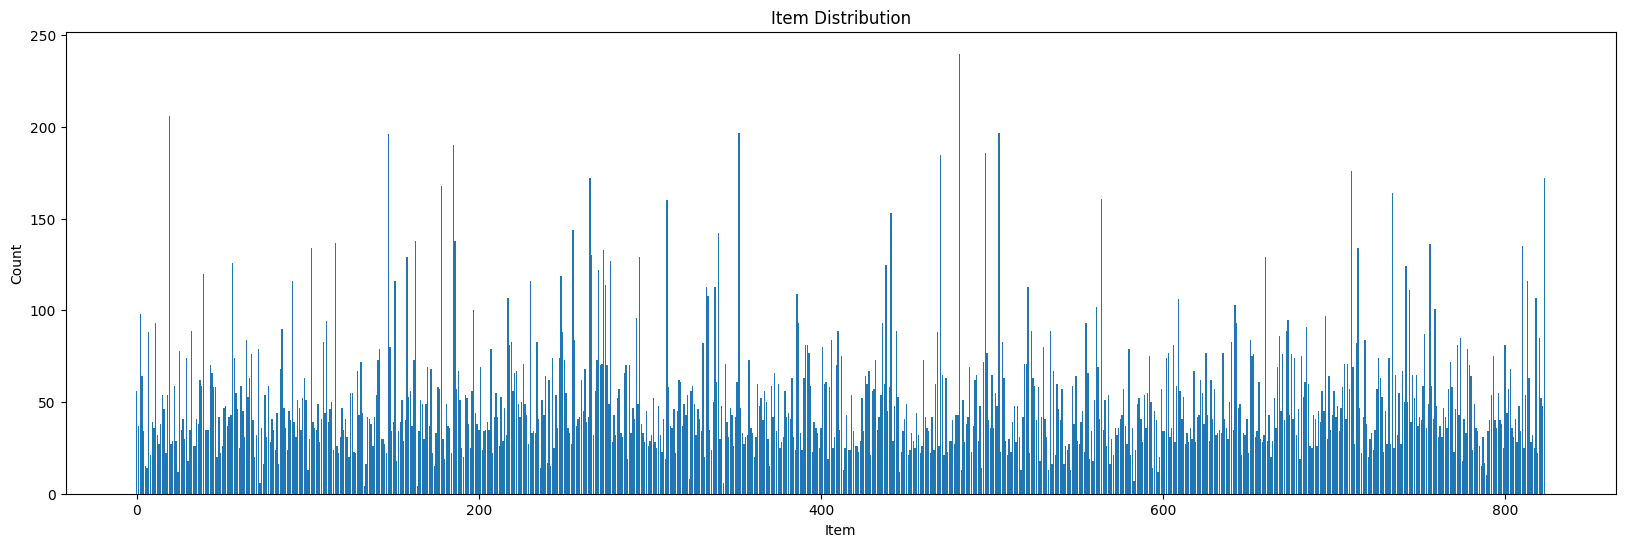

In [20]:
# Plot the item distribution
plt.figure(figsize=(20, 6))
plt.bar(item_dis['Class'], item_dis['Count'])
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('Item Distribution')
plt.show()

In [21]:
# Create train test split 
X_train, X_val, y_label_train, y_label_val = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)
# onehot encoding on labels corresponding to num_items
y_train = tf.keras.utils.to_categorical(y_label_train, num_classes=NUM_ITEMS+1)
y_val = tf.keras.utils.to_categorical(y_label_val, num_classes=NUM_ITEMS+1)

In [22]:
print("Input Shape: " + str(X_train.shape))
print("Trainingset Size: " + str(len(X_train)))
print("Validationset Size: " + str(len(X_val)))

Input Shape: (33402, 4)
Trainingset Size: 33402
Validationset Size: 8351


In [23]:
# clear memory space
del train, length, unique_classes, class_counts, item_dis
gc.collect()

51636

# 5. Modeling & Evaluation

In [24]:
################# MODEL 1: GRU #####################

model = Sequential() 

# adding embedding layer
model.add(Embedding(NUM_ITEMS+1, 4, input_length=X_train.shape[1]))

# adding GRU layer
model.add(GRU(units = 64))
model.add(Dropout(0.1))

# adding dense output layer
model.add(Dense(NUM_ITEMS+1, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 4)              3300      
                                                                 
 gru (GRU)                   (None, 64)                13440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 825)               53625     
                                                                 
Total params: 70365 (274.86 KB)
Trainable params: 70365 (274.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# define top-k accuracy metrics

def top_100_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=100)

def top_50_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=50)

def top_10_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=10)

def top_5_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=5)

def top_1_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=1)

In [28]:
# train the model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[top_100_categorical_accuracy, top_50_categorical_accuracy, top_10_categorical_accuracy, top_5_categorical_accuracy, top_1_categorical_accuracy,tf.keras.metrics.Recall(top_k=5), tf.keras.metrics.Precision(top_k=5),  tf.keras.metrics.Recall(top_k=10), tf.keras.metrics.Precision(top_k=10), tf.keras.metrics.Recall(top_k=50), tf.keras.metrics.Precision(top_k=50)])

history = model.fit(X_train,y_train, epochs=50, validation_data=(X_val, y_val), verbose=1, batch_size= 128)

# batch size 64, 128 works good

Epoch 1/50
261/261 [==============================] - 9s 22ms/step - loss: 6.6006 - top_100_categorical_accuracy: 0.2529 - top_50_categorical_accuracy: 0.1577 - top_10_categorical_accuracy: 0.0414 - top_5_categorical_accuracy: 0.0224 - top_1_categorical_accuracy: 0.0055 - recall: 0.0224 - precision: 0.0045 - recall_1: 0.0414 - precision_1: 0.0041 - recall_2: 0.1577 - precision_2: 0.0032 - val_loss: 6.5007 - val_top_100_categorical_accuracy: 0.2832 - val_top_50_categorical_accuracy: 0.1711 - val_top_10_categorical_accuracy: 0.0489 - val_top_5_categorical_accuracy: 0.0244 - val_top_1_categorical_accuracy: 0.0046 - val_recall: 0.0244 - val_precision: 0.0049 - val_recall_1: 0.0489 - val_precision_1: 0.0049 - val_recall_2: 0.1711 - val_precision_2: 0.0034
Epoch 2/50
261/261 [==============================] - 5s 18ms/step - loss: 6.4318 - top_100_categorical_accuracy: 0.3184 - top_50_categorical_accuracy: 0.1969 - top_10_categorical_accuracy: 0.0567 - top_5_categorical_accuracy: 0.0331 - top

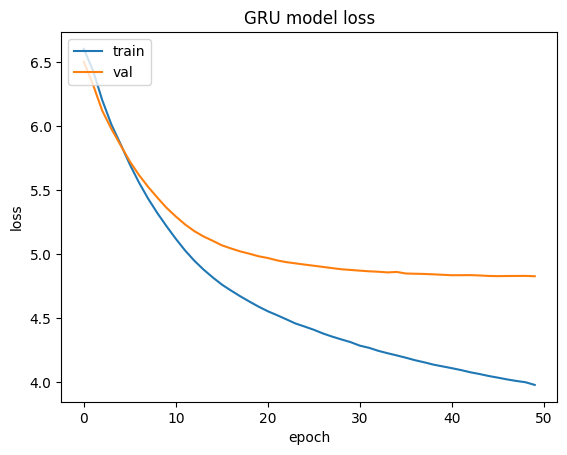

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

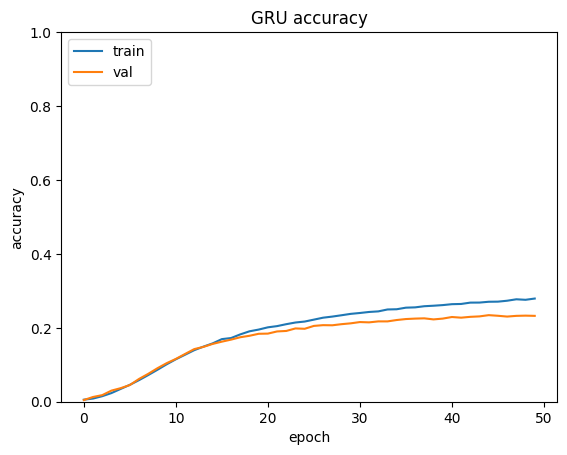

In [30]:
plt.plot(history.history['top_1_categorical_accuracy'])
plt.plot(history.history['val_top_1_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('GRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

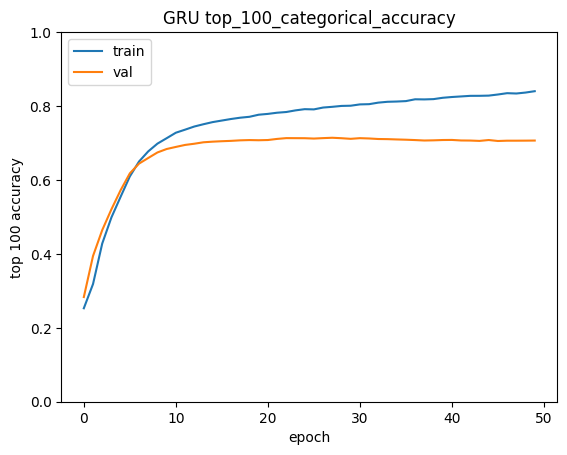

In [31]:
plt.plot(history.history['top_100_categorical_accuracy'])
plt.plot(history.history['val_top_100_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('GRU top_100_categorical_accuracy')
plt.ylabel('top 100 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


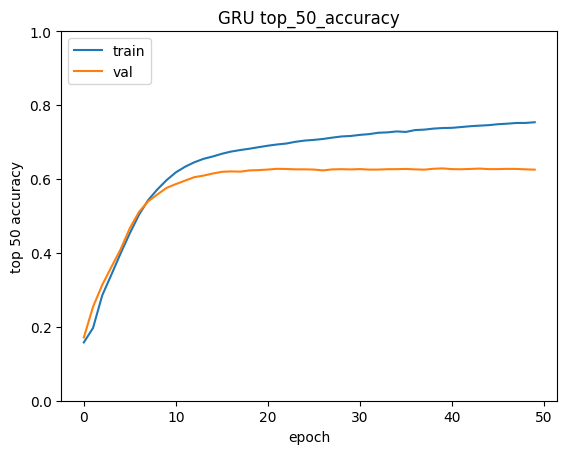

In [32]:
plt.plot(history.history['top_50_categorical_accuracy'])
plt.plot(history.history['val_top_50_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('GRU top_50_accuracy')
plt.ylabel('top 50 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

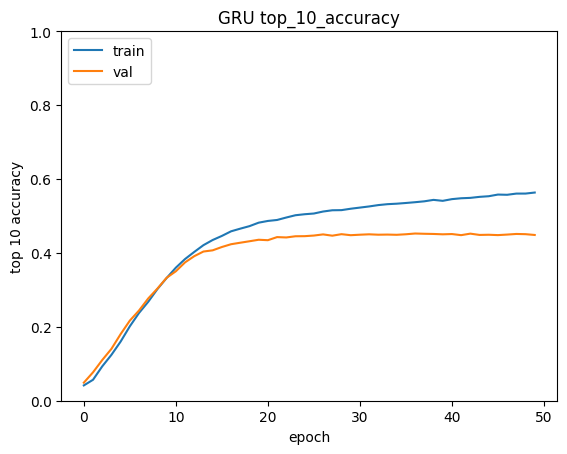

In [33]:
plt.plot(history.history['top_10_categorical_accuracy'])
plt.plot(history.history['val_top_10_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('GRU top_10_accuracy')
plt.ylabel('top 10 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

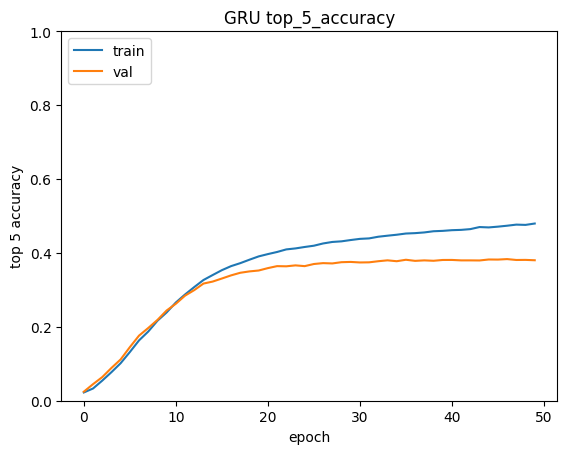

In [34]:
plt.plot(history.history['top_5_categorical_accuracy'])
plt.plot(history.history['val_top_5_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('GRU top_5_accuracy')
plt.ylabel('top 5 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

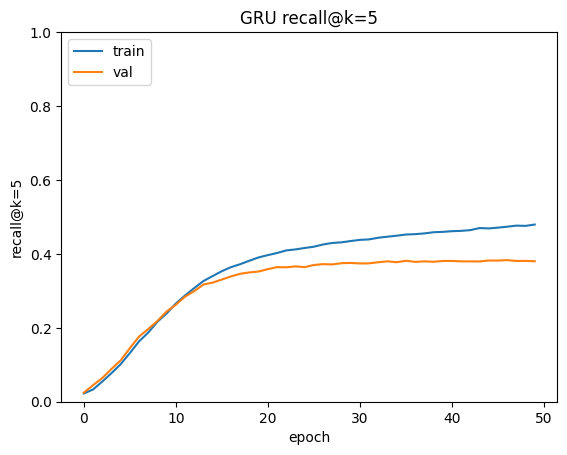

In [35]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.ylim(0, 1)
plt.title('GRU recall@k=5')
plt.ylabel('recall@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

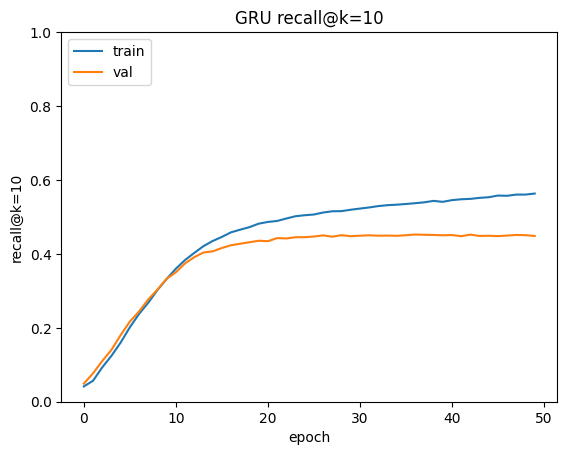

In [36]:
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.ylim(0, 1)
plt.title('GRU recall@k=10')
plt.ylabel('recall@k=10')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

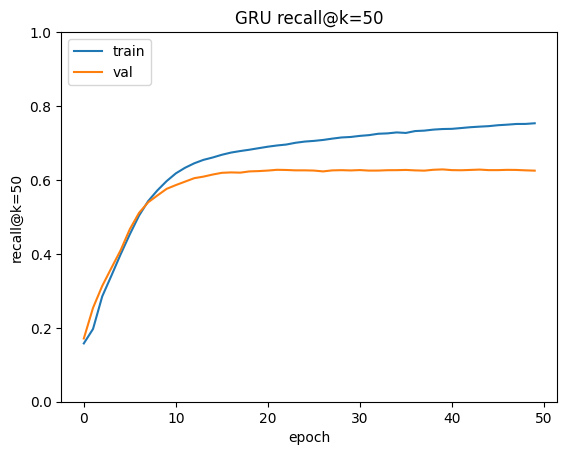

In [37]:
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.ylim(0, 1)
plt.title('GRU recall@k=50')
plt.ylabel('recall@k=50')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

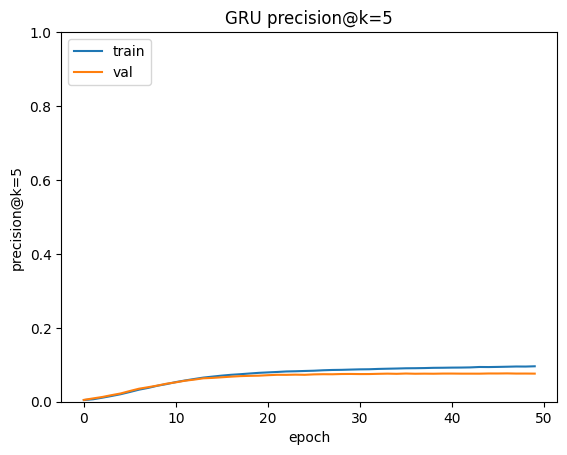

In [38]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylim(0, 1)
plt.title('GRU precision@k=5')
plt.ylabel('precision@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

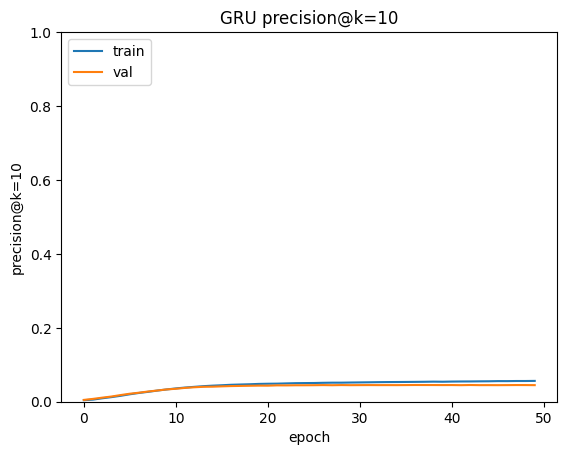

In [39]:
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.ylim(0, 1)
plt.title('GRU precision@k=10')
plt.ylabel('precision@k=10')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# Print all values for all the metrics that we calculated and plotted for the GRU approach to see the exact values

for metric in history.history.keys():
    print("METRIC: " + str(metric))
    
    h_values = history.history[metric]

    h_values = [round(num,2) for num in h_values]

    print(h_values)
    print("MAX VALUE: ", str(max(h_values)))

    print("---------------------------")


METRIC: loss
[6.6, 6.45, 6.27, 6.07, 5.86, 5.68, 5.54, 5.42, 5.3, 5.2, 5.11, 5.02, 4.94, 4.87, 4.81, 4.76, 4.72, 4.67, 4.63, 4.59, 4.55, 4.52, 4.49, 4.46, 4.43, 4.41, 4.38, 4.36, 4.33, 4.31, 4.29, 4.27, 4.25, 4.22, 4.21, 4.19, 4.17, 4.16, 4.14, 4.12, 4.1, 4.09, 4.07, 4.05, 4.05, 4.04, 4.02, 4.01, 4.0, 3.98]
MAX VALUE:  6.6
---------------------------
METRIC: top_100_categorical_accuracy
[0.26, 0.31, 0.4, 0.48, 0.55, 0.61, 0.65, 0.68, 0.7, 0.72, 0.73, 0.74, 0.75, 0.75, 0.76, 0.76, 0.76, 0.77, 0.77, 0.77, 0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.84]
MAX VALUE:  0.84
---------------------------
METRIC: top_50_categorical_accuracy
[0.16, 0.19, 0.26, 0.33, 0.41, 0.47, 0.51, 0.55, 0.58, 0.6, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69, 0.7, 0.7, 0.7, 0.7, 0.7, 0.71, 0.71, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73

In [64]:
################# MODEL 2: LSTM #####################

model = Sequential() 

#adding embedding layer
model.add(Embedding(NUM_ITEMS+1, 4, input_length=X_train.shape[1]))

#adding LSTM layer
model.add(LSTM(units = 64))
model.add(Dropout(0.1))

#adding dense output layer
model.add(Dense(NUM_ITEMS+1, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 4)              3300      
                                                                 
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 825)               53625     
                                                                 
Total params: 74589 (291.36 KB)
Trainable params: 74589 (291.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# train the model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[top_100_categorical_accuracy, top_50_categorical_accuracy, top_10_categorical_accuracy, top_5_categorical_accuracy, top_1_categorical_accuracy,tf.keras.metrics.Recall(top_k=5), tf.keras.metrics.Precision(top_k=5),  tf.keras.metrics.Recall(top_k=10), tf.keras.metrics.Precision(top_k=10), tf.keras.metrics.Recall(top_k=50), tf.keras.metrics.Precision(top_k=50)])

history = model.fit(X_train,y_train, epochs=50, validation_data=(X_val, y_val), verbose=1, batch_size=128)

Epoch 1/50
261/261 [==============================] - 8s 21ms/step - loss: 6.6117 - top_100_categorical_accuracy: 0.2551 - top_50_categorical_accuracy: 0.1569 - top_10_categorical_accuracy: 0.0415 - top_5_categorical_accuracy: 0.0218 - top_1_categorical_accuracy: 0.0051 - recall_3: 0.0218 - precision_3: 0.0044 - recall_4: 0.0415 - precision_4: 0.0041 - recall_5: 0.1569 - precision_5: 0.0031 - val_loss: 6.5233 - val_top_100_categorical_accuracy: 0.2766 - val_top_50_categorical_accuracy: 0.1715 - val_top_10_categorical_accuracy: 0.0469 - val_top_5_categorical_accuracy: 0.0245 - val_top_1_categorical_accuracy: 0.0044 - val_recall_3: 0.0245 - val_precision_3: 0.0049 - val_recall_4: 0.0469 - val_precision_4: 0.0047 - val_recall_5: 0.1715 - val_precision_5: 0.0034
Epoch 2/50
261/261 [==============================] - 5s 18ms/step - loss: 6.4906 - top_100_categorical_accuracy: 0.2783 - top_50_categorical_accuracy: 0.1715 - top_10_categorical_accuracy: 0.0464 - top_5_categorical_accuracy: 0.02

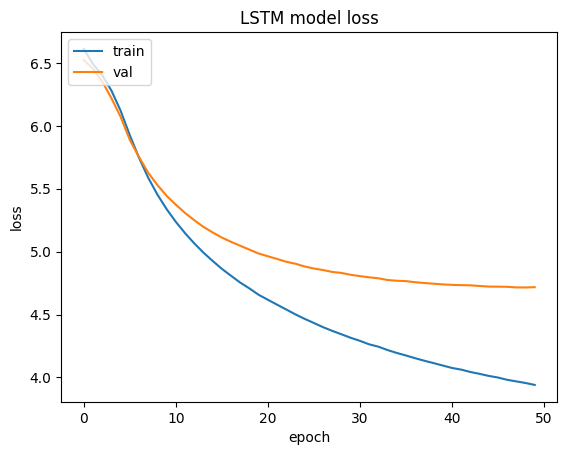

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

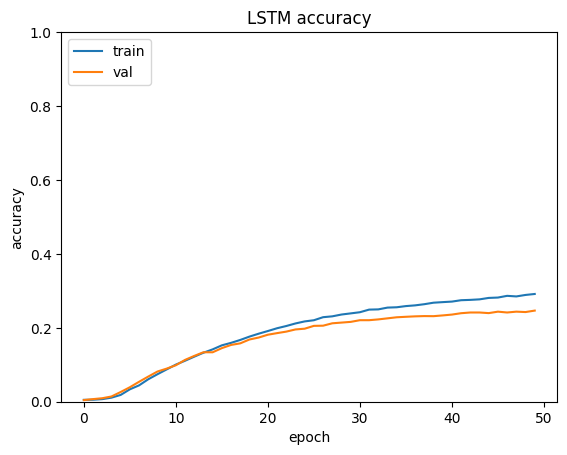

In [67]:
plt.plot(history.history['top_1_categorical_accuracy'])
plt.plot(history.history['val_top_1_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

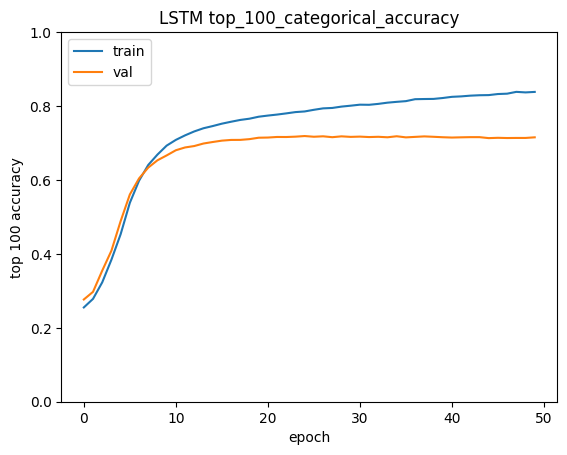

In [68]:
plt.plot(history.history['top_100_categorical_accuracy'])
plt.plot(history.history['val_top_100_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('LSTM top_100_categorical_accuracy')
plt.ylabel('top 100 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


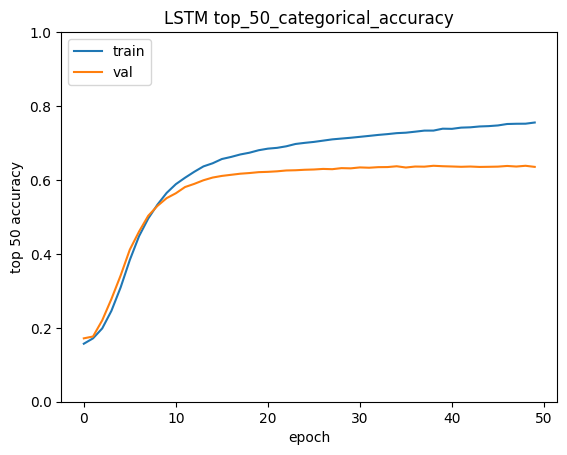

In [69]:
plt.plot(history.history['top_50_categorical_accuracy'])
plt.plot(history.history['val_top_50_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('LSTM top_50_categorical_accuracy')
plt.ylabel('top 50 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

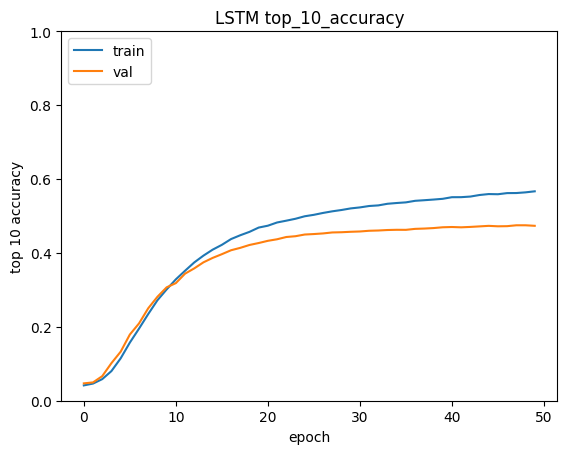

In [70]:
plt.plot(history.history['top_10_categorical_accuracy'])
plt.plot(history.history['val_top_10_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('LSTM top_10_accuracy')
plt.ylabel('top 10 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

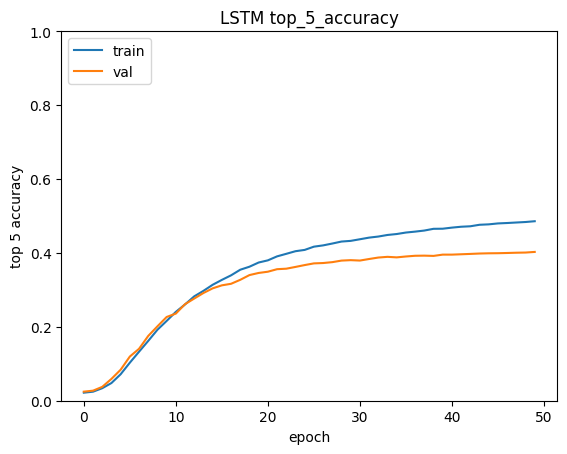

In [71]:
plt.plot(history.history['top_5_categorical_accuracy'])
plt.plot(history.history['val_top_5_categorical_accuracy'])
plt.ylim(0, 1)
plt.title('LSTM top_5_accuracy')
plt.ylabel('top 5 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

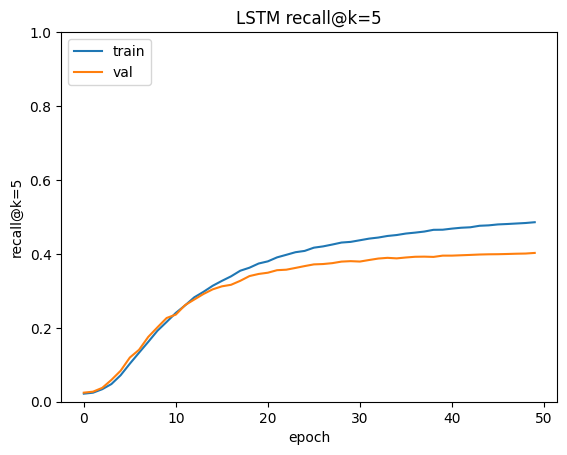

In [72]:
plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])
plt.ylim(0, 1)
plt.title('LSTM recall@k=5')
plt.ylabel('recall@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

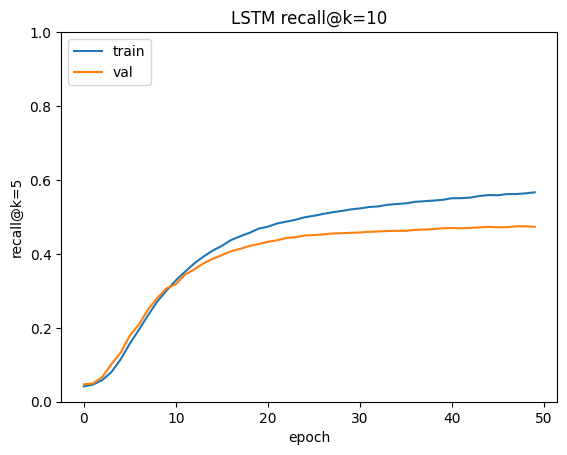

In [73]:
plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])
plt.ylim(0, 1)
plt.title('LSTM recall@k=10')
plt.ylabel('recall@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

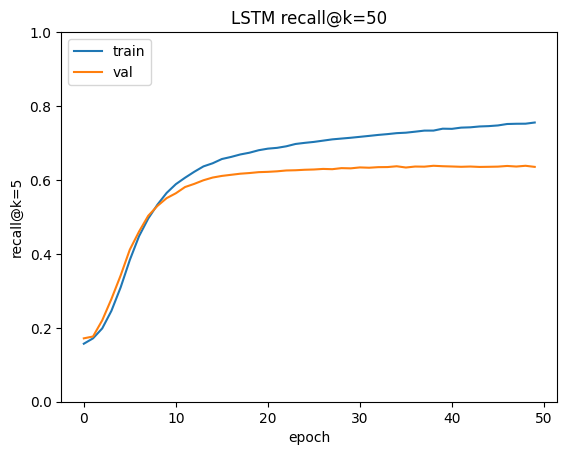

In [74]:
plt.plot(history.history['recall_5'])
plt.plot(history.history['val_recall_5'])
plt.ylim(0, 1)
plt.title('LSTM recall@k=50')
plt.ylabel('recall@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

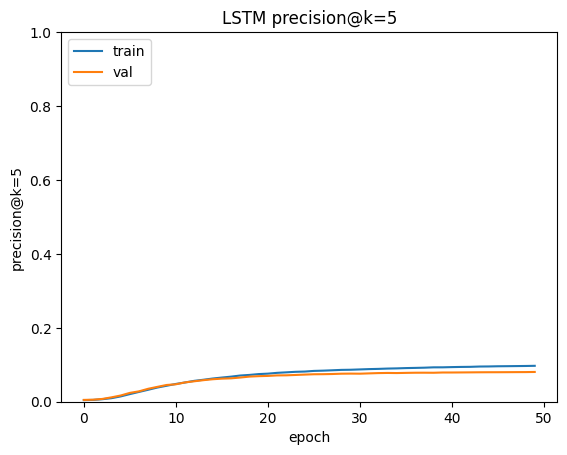

In [75]:
plt.plot(history.history['precision_3'])
plt.plot(history.history['val_precision_3'])
plt.ylim(0, 1)
plt.title('LSTM precision@k=5')
plt.ylabel('precision@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

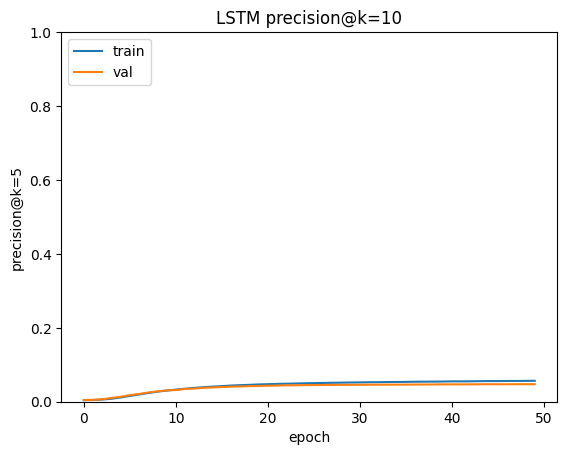

In [76]:
plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])
plt.ylim(0, 1)
plt.title('LSTM precision@k=10')
plt.ylabel('precision@k=5')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
# Print all values for all the metrics that we calculated and plotted for the LSTM approach to see the exact values

for metric in history.history.keys():
    print("METRIC: " + str(metric))
    
    h_values = history.history[metric]

    h_values = [round(num,2) for num in h_values]

    print(h_values)
    print("MAX VALUE: ", str(max(h_values)))

    print("---------------------------")

METRIC: loss
[6.61, 6.49, 6.39, 6.26, 6.1, 5.92, 5.76, 5.62, 5.49, 5.37, 5.27, 5.17, 5.09, 5.02, 4.94, 4.88, 4.82, 4.77, 4.72, 4.68, 4.63, 4.59, 4.55, 4.52, 4.49, 4.46, 4.42, 4.39, 4.37, 4.34, 4.31, 4.29, 4.27, 4.24, 4.22, 4.2, 4.18, 4.16, 4.14, 4.12, 4.1, 4.08, 4.07, 4.05, 4.04, 4.02, 4.0, 3.99, 3.98, 3.96]
MAX VALUE:  6.61
---------------------------
METRIC: top_100_categorical_accuracy
[0.25, 0.28, 0.33, 0.39, 0.46, 0.54, 0.59, 0.63, 0.66, 0.68, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.75, 0.76, 0.76, 0.76, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.8, 0.8, 0.8, 0.8, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.83, 0.83, 0.84]
MAX VALUE:  0.84
---------------------------
METRIC: top_50_categorical_accuracy
[0.16, 0.17, 0.21, 0.26, 0.32, 0.39, 0.44, 0.49, 0.52, 0.55, 0.58, 0.6, 0.62, 0.63, 0.64, 0.65, 0.65, 0.66, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69, 0.69, 0.7, 0.7, 0.7, 0.7, 0.71, 0.71, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.73, 0.73, 0

# 6. Deployment

In [63]:
# We can deploy our Recommender System based on our RNN-Architecture.
# In a session we can give our model the last 4 articles the user interacted with and it will recommend the next 5 best articles to the user

# Example
# Taking a random session from the validationset

past_session_sequence = X_val[173]

past_session_sequence = past_session_sequence.reshape(1, 4)

predictions = model.predict(past_session_sequence)[0]

recommended_items = np.argsort(predictions)[-10:]  # Get the indices of top probabilities

top_probabilities = predictions[recommended_items]  # Extract the top probabilities

print("Given your past session: " + str(list(past_session_sequence[0])))
print("Those articles could be interesting for you:")
print(recommended_items)
print("with the following probabilities: ")
print(str(top_probabilities))
print("True Item: ", str(y_label_train[173]))

1/1 [==============================] - 0s 39ms/step
Given your past session: [0, 605, 19, 729]
Those articles could be interesting for you:
[454 155 528 259 340 731 811 741 580 316]
with the following probabilities: 
[0.01898744 0.02071209 0.02219201 0.02501081 0.02643097 0.02729303
 0.03461536 0.04766903 0.05141114 0.06292391]
True Item:  340
